<a href="https://colab.research.google.com/github/Masoud-Ghasemian/BERT/blob/master/Tweeter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 757kB 2.9MB/s 
     |████████████████████████████████| 3.0MB 14.3MB/s 
     |████████████████████████████████| 1.1MB 29.5MB/s 
     |████████████████████████████████| 890kB 23.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=d3a4496e686ad42d038b4351406ec66d182cc3c5a8f61345abce86ef5c318af1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('train.csv') 

In [4]:
df.head(10)

,target,ids,date,flag,user,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
5,0,2052380495,Sat Jun 06 00:32:16 PDT 2009,NO_QUERY,Yengching,Going to miss Pastor's sermon on Faith...
6,4,1983449090,Sun May 31 13:10:36 PDT 2009,NO_QUERY,jessig06,on lunch....dj should come eat with me
7,0,2245479748,Fri Jun 19 16:11:29 PDT 2009,NO_QUERY,felicityfuller,@piginthepoke oh why are you feeling like that?
8,0,1770705699,Mon May 11 22:01:32 PDT 2009,NO_QUERY,stephiiheyy,gahh noo!peyton needs to live!this is horrible
9,4,1970386589,Sat May 30 03:39:34 PDT 2009,NO_QUERY,wyndwitch,@mrstessyman thank you glad you like it! There...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16000 non-null  int64 
 1   ids     16000 non-null  int64 
 2   date    16000 non-null  object
 3   flag    16000 non-null  object
 4   user    16000 non-null  object
 5   text    16000 non-null  object
dtypes: int64(2), object(4)
memory usage: 750.1+ KB


In [6]:
df.shape

(16000, 6)

In [7]:
def to_sentiment (rating):
  rating = int(rating)
  if rating ==0:
    return 0
  else:
    return 1


In [8]:
df['sentiment'] = df.target.apply(to_sentiment)

In [9]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text', 'sentiment'], dtype='object')

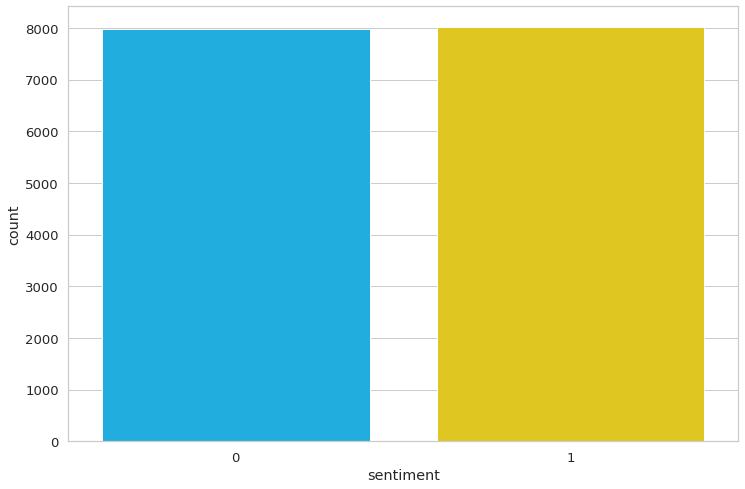

In [10]:
sns.countplot(df.sentiment)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
class GPReviewDataset (Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets 
    self.tokenizer = tokenizer
    self.max_len = max_len 

  def __len__(self):
    return(len(self.reviews))

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens = True ,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt',
      truncation = True
    )

    return {
        'review_text' : review,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }




In [14]:
MAX_LEN = 64
BATCH_SIZE = 16
EPOCHS = 10

In [15]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [16]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(14400, 7)
(800, 7)
(800, 7)


In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews = df.text.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [18]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
bert_model = BertModel.from_pretrained('bert-base-cased')

In [20]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert =BertModel.from_pretrained('bert-base-cased' )
    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [21]:
model = SentimentClassifier(2)
model = model.to(device)

In [122]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [123]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [124]:
model(input_ids, attention_mask)

tensor([[-0.2705, -0.4343],
        [-0.4271,  0.3655],
        [ 0.4133, -0.4157],
        [ 0.0614,  0.5749],
        [ 0.5449,  0.1343],
        [-0.1963, -0.0471],
        [ 0.2574,  1.0988],
        [ 0.4217, -0.0101],
        [-0.6753, -0.1662],
        [ 0.0827, -0.0478],
        [ 0.2931, -0.2089],
        [ 0.7856,  0.2857],
        [ 0.1348,  0.3586],
        [ 0.0240,  0.0699],
        [ 0.3951, -0.6232],
        [-0.2636, -0.3657]], grad_fn=<AddmmBackward>)

In [125]:
F.softmax(model(input_ids, attention_mask))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.4209, 0.5791],
        [0.6737, 0.3263],
        [0.5032, 0.4968],
        [0.6700, 0.3300],
        [0.3621, 0.6379],
        [0.6468, 0.3532],
        [0.2953, 0.7047],
        [0.5312, 0.4688],
        [0.6326, 0.3674],
        [0.5750, 0.4250],
        [0.5565, 0.4435],
        [0.6830, 0.3170],
        [0.4674, 0.5326],
        [0.4764, 0.5236],
        [0.4426, 0.5574],
        [0.7042, 0.2958]], grad_fn=<SoftmaxBackward>)

In [22]:
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
len(train_data_loader)

900

In [24]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    _, preds =  torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    

  return correct_predictions.double() / n_examples , np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )
      _, preds =  torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())


  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-'*10)
  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )
  print(f'Train loss = {train_loss} accuracy = {train_acc}')


  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )
  print(f'Val loss = {val_loss} accuracy = {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss = 0.4897337649348709 accuracy = 0.765625
Val loss = 0.4497045135498047 accuracy = 0.8125
Epoch 2/10
----------
Train loss = 0.29528586694349845 accuracy = 0.8854861111111111
Val loss = 0.5926402595639229 accuracy = 0.80125
Epoch 3/10
----------
Train loss = 0.17609692036484678 accuracy = 0.9497222222222222
Val loss = 0.8551127419620752 accuracy = 0.81375
Epoch 4/10
----------
Train loss = 0.12378961102623079 accuracy = 0.9695138888888889
Val loss = 0.8332848116755486 accuracy = 0.8200000000000001
Epoch 5/10
----------
Train loss = 0.08015076448313065 accuracy = 0.9813194444444444
Val loss = 1.1560644710063934 accuracy = 0.80375
Epoch 6/10
----------
Train loss = 0.052031600933728946 accuracy = 0.9889583333333334
Val loss = 1.2851254034042359 accuracy = 0.8075
Epoch 7/10
----------
Train loss = 0.03115474519216352 accuracy = 0.9927083333333333
Val loss = 1.3905945563316344 accuracy = 0.8075
Epoch 8/10
----------
Train loss = 0.024384182618103094 accuracy

(0.0, 1.0)

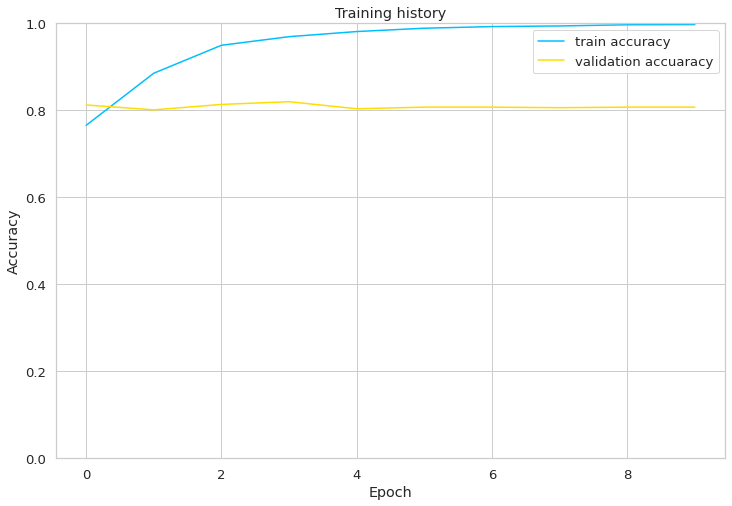

In [27]:
plt.plot(history['train_acc'], label = 'train accuracy')
plt.plot(history['val_acc'], label = 'validation accuaracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

In [28]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.80625

In [30]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  predictions_probs = []
  real_values = []

  with torch.no_grad():

    for d in data_loader:

      texts = d['review']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)


      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim = 1)

      review_texts.extend(texts)
      predictions.extend(preds)
      predictions_probs.extend(outputs)
      real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      predictions_probs = torch.stack(predictions_probs).cpu()
      real_values = torch.stack(real_values).cpu()

      return review_texts, predictions, predictions_probs, real_values